Goals

1. As real-time, high-freq as possible data points about the global economy
2. Start with major yield curves and show composition / contributions to total yield curves of various countries - where are yield curves flattening, where steepening (contrib are to one global yieldcurve, weighted by GDP?)
3. Include nowcasts
4. Scrape important headlines?



### Import libraries

In [4]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas_datareader.data as web
import datetime

%matplotlib inline
plt.close('all')

#### Load data US treasury bond yields

In [ ]:
yieldcurve_full_data = quandl.get("USTREASURY/YIELD", authtoken="e4FyZJfz6ukboUWG4Pm_")

In [ ]:
yieldcurve_DF = pd.DataFrame(yieldcurve_full_data)
yieldcurve_full_data.to_csv("yieldcurve_full_data.csv")    # dump into CSV file

In [ ]:
yieldcurve_DF.tail()

#### Plot US Treasury yields for different tenors 

In [ ]:
yieldcurve_DF.plot(subplots=True, layout=(4,3), figsize=(16, 10))
plt.show()

In [ ]:
#yieldcurve_DF.plot(colormap="cubehelix",figsize=(15, 15)) # subplots=True, layout=(4,3))
#plt.show()

In [ ]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 3, 27)

In [ ]:
gdp = web.DataReader('GDP', 'fred', start, end)
gdp.head()

In [ ]:
gdp.loc['2013-01-01']

In [ ]:
inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred', start, end)

In [ ]:
inflation.head()

#### 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity 

In [ ]:
fredyc = web.DataReader(['T10Y3MM'], 'fred', start, end)

In [ ]:
fredyc.head()

In [ ]:
fredyc.tail()

#### 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity 

In [ ]:
TSY2y10y_fred = web.DataReader(['T10Y2Y'], 'fred', start, end)

In [ ]:
TSY2y10y_fred.tail()

In [ ]:
# finalised dataframe write to different file  pandasDF.to_csv("......csv")

In [5]:
import os
os.getcwd()
os.listdir()

['.ipynb_checkpoints',
 '6m.csv',
 'DE10y.csv',
 'DE1y.csv',
 'DE20y.csv',
 'DE2y.csv',
 'DE30y.csv',
 'DE5y.csv',
 'DE6m.csv',
 'Macro dashboard-backup .ipynb',
 'Macro dashboard.ipynb',
 'ust.csv',
 'yieldcurve_full_data.csv']

In [ ]:
yieldcurve_DF.columns

In [ ]:
TSY3m2y =  yieldcurve_DF['2 YR'] - yieldcurve_DF['3 MO']

In [ ]:
TSY3m2y.plot()

In [ ]:
TSY2y10y_quandl =  yieldcurve_DF['10 YR'] - yieldcurve_DF['2 YR']

In [ ]:
TSY2y10y_quandl.plot()

In [ ]:
TSY3m10y_quandl =  yieldcurve_DF['10 YR'] - yieldcurve_DF['3 MO']

In [ ]:
TSY3m10y_quandl.plot()

In [ ]:
TSY2y10y_quandl.loc['20100102':].plot(figsize=(16, 8))
plt.show()

In [ ]:
TSY2y10y_fred.loc['20100102':].plot(figsize=(16, 8))
plt.show()

#### Checking for missing values

In [6]:
import missingno as msno

In [ ]:
msno.bar(yieldcurve_DF.sample(7295), figsize=(10, 4))
plt.show()

## Germany Bund yields and curve

In [ ]:
# assigns URL for Bund instruments to input variable
DE6m_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3210&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE1y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3211&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE2y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3213&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE5y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3219&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE10y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3229&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE20y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3449&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE30y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3500&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")

In [ ]:
def bunds_clean(URL, tenor):
    """
    transforms very poorly formatted CSV file from German Bundesbank
    into usable file for analysis and visualtion
    """
    DF = pd.read_csv(URL, sep=';')
    
    assert type(tenor) == str, "Tenor needs to be a string"
        
    # remove rows without relevant data
    DF = DF[4:-1]
    # rename columns to give meaningful name
    new_columns = DF.columns.values
    new_columns[0] = 'DATE'
    new_columns[1] = tenor 
#   new_columns[1] = 'RATE'
    DF.columns = new_columns
    
    # assign last column to variable 'dropcolumn'
    dropcolumn = DF.columns[2]
    # use dropcolumn to remove rows that have missing values (indicated by string in German instead of NaN)
    DF = DF[DF[dropcolumn] != 'Kein Wert vorhanden']
    # now remove last column 
    DF = DF.drop([dropcolumn], axis=1)

    # reset dataframe index to 0 - was not the case because we removed rows earlier
    DF.reset_index(drop=True, inplace=True)
    
    # replace German comma (,) with dot in RATE column
    DF[tenor] = [x.replace(',', '.') for x in DF[tenor]]
#   DF['RATE'] = [x.replace(',', '.') for x in DF['RATE']]

    # convert RATE column values from string to float
#   DF.RATE = DF.RATE.astype(float)
    DF[tenor] = DF[tenor].astype('float')
    # convert DATE column values from string to datetime
    DF['DATE'] = pd.to_datetime(DF['DATE'])

    # replace dataframe index column with DATE column
    DF.set_index(['DATE'], drop=True, inplace=True)
    
    return DF

In [50]:
# calls data cleaning function and passes URL into it, backs up output as CSV file afterwards


    

tenor = '6m'
DE6m = bunds_clean(DE6m_input, tenor)
DE6m.to_csv("DE6m.csv")




In [ ]:
# calls data cleaning function and passes URL into it, backs up output as CSV file afterwards


In [52]:
tenor = '1y'
DE1y = bunds_clean(DE1y_input, tenor)
DE1y.to_csv("DE1y.csv")

DE2y = bunds_clean(DE2y_input, tenor)
DE2y.to_csv("DE2y.csv")

DE5y = bunds_clean(DE5y_input, tenor)
DE5y.to_csv("DE5y.csv")

DE10y = bunds_clean(DE10y_input, tenor)
DE10y.to_csv("DE10y.csv")

DE20y = bunds_clean(DE20y_input, tenor)
DE20y.to_csv("DE20y.csv")

DE30y = bunds_clean(DE30y_input, tenor)
DE30y.to_csv("DE30y.csv")

In [ ]:
DE2y.tail()

In [ ]:
DE10y.tail()

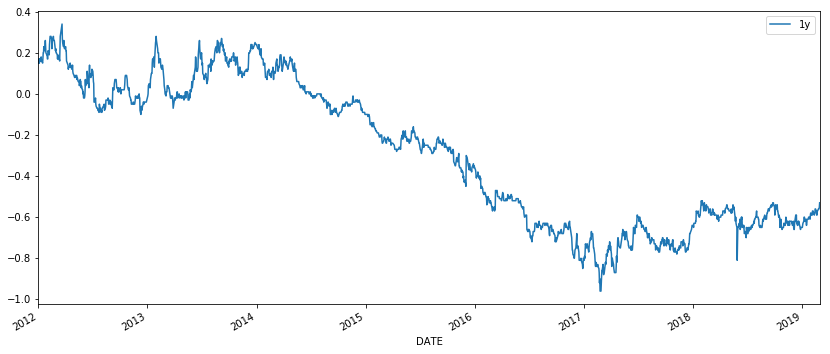

In [54]:
start = '20120101'
end = ''
DE2y.loc[start:].plot(figsize=(14, 6))
plt.show()

In [ ]:
start = '20120101'
end = ''
DE10y.loc[start:].plot(figsize=(14, 6))
plt.show()

In [ ]:
DE2y10y =  DE10y['RATE'] - DE2y['RATE']

In [ ]:
DE2y10y.loc[start:].plot(figsize=(14, 6))
plt.show()

In [ ]:
# Todo?
# load daily but append only last row (if new data, not on weekends!) to CSV file
# https://codereview.stackexchange.com/questions/104050/read-daily-files-and-concatenate-them

# One big overview welcome screen - then links (or further down details): nowcast, vix, YC, crude, gold, spx. eur, jpy..

# add more bund tenors, add Aussie, Canada, China, India, Russia, etc etc G10?

# add little coloured overview +/- day, week, month, quarter, year, 2yr? for quick overview
# then show charts 

#GDP nowcast

# inflation? 5y5y breakevens?

# VIX
#live from google finance 
#https://www.google.com/search?source=hp&ei=lMN6XIqtBu6Bk74PvbiKsA0&q=vix+hourly+data&btnK=Google+Search&oq=hourly+data+vix&gs_l=psy-ab.3.0.0i22i30.271.5443..6841...6.0..1.148.1338.21j1......0....1..gws-wiz.....6..35i39j0i67j0j0i203.iMHKCyA6mzw
# history from Fred
# more vol indics: https://fred.stlouisfed.org/categories/32425

# interactive: sliders to change dates etc etc

In [7]:
# assigns URL for Bund instruments to input variable
DE6m_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3210&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE1y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3211&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE2y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3213&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE5y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3219&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE10y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3229&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE20y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3449&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")
DE30y_input = ("https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3500&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=")

In [46]:
def bunds_clean(URL, tenor):
    """
    transforms very poorly formatted CSV file from German Bundesbank
    into usable file for analysis and visualtion
    """
    DF = pd.read_csv(URL, sep=';')
    
    assert type(tenor) == str, "Tenor needs to be a string"
        
    # remove rows without relevant data
    DF = DF[4:-1]
    # rename columns to give meaningful name
    new_columns = DF.columns.values
    new_columns[0] = 'DATE'
    new_columns[1] = tenor 
#   new_columns[1] = 'RATE'
    DF.columns = new_columns
    
    # assign last column to variable 'dropcolumn'
    dropcolumn = DF.columns[2]
    # use dropcolumn to remove rows that have missing values (indicated by string in German instead of NaN)
    DF = DF[DF[dropcolumn] != 'Kein Wert vorhanden']
    # now remove last column 
    DF = DF.drop([dropcolumn], axis=1)

    # reset dataframe index to 0 - was not the case because we removed rows earlier
    DF.reset_index(drop=True, inplace=True)
    
    # replace German comma (,) with dot in RATE column
    DF[tenor] = [x.replace(',', '.') for x in DF[tenor]]
#   DF['RATE'] = [x.replace(',', '.') for x in DF['RATE']]

    # convert RATE column values from string to float
#   DF.RATE = DF.RATE.astype(float)
    DF[tenor] = DF[tenor].astype('float')
    # convert DATE column values from string to datetime
    DF['DATE'] = pd.to_datetime(DF['DATE'])

    # replace dataframe index column with DATE column
    DF.set_index(['DATE'], drop=True, inplace=True)
    
    return DF

def instrument_names(x):
    y = [0] * len(x)
    for i in x:
        index = x.index(i)
        if index < len(x):
            x[index] = 'DE'+ i
            y[index] = x[index] + '_input'
    return x, y

def call_clean(bond, file, tenor):
    for i in tenor:
        print(tenor[i])
        print(file)
        #result = bunds_clean(file, tenor)
        #result.to_csv("i.csv")
        #return result
        

#def call_clean(bond, tenor):
#    for i in bond:
#        file_name = "i + '_input'"
#        result = bunds_clean(file_name, tenor)
#        result.to_csv("i.csv")
#        return result

In [49]:
tenor = ['6m', '1y', '2y', '5y','10y', '20y', '30y']
results = instrument_names(tenor[:])
instruments = results[0]
file_name = results[1]
print(instruments)
print(file_name)


#call_clean(instruments, file_name, tenor)

['DE6m', 'DE1y', 'DE2y', 'DE5y', 'DE10y', 'DE20y', 'DE30y']
['DE6m_input', 'DE1y_input', 'DE2y_input', 'DE5y_input', 'DE10y_input', 'DE20y_input', 'DE30y_input']
